## compare bloom timing versus S3 ferry chl
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [2]:
Chl_N=1.8
pvars=['diatoms','flagellates','ciliates']
cdict={'diatoms':'darkgreen','flagellates':'mediumblue','ciliates':'maroon','+'.join(pvars):'k'}

In [3]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [4]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))
df2=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))
df=pd.concat([df1.drop(df1[df1.TimeUTC<'2015'].index),df2.drop(df2[df2.TimeUTC>'2016'].index)],ignore_index=True)

/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]

In [6]:
df=df.assign(dts=dts)

In [7]:
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

In [8]:
df.head()

,TimeUTC,CDOM,CDOMQC,Chlorophyll_ug,ChlQC,Turbidity_NTU,TurbQC,Lat,LatQC,Lon,LongQC,dts
0,2015-01-01T00:00:08.461Z,16.5912,1,1.2463,1,4.5548,1,49.094471,8,-123.426450,8,2015-01-01 00:00:08
1,2015-01-01T00:00:17.515Z,16.948,1,1.2342,1,4.7864,1,49.094835,8,-123.427538,8,2015-01-01 00:00:17
2,2015-01-01T00:00:27.689Z,16.7696,1,1.2221,1,4.632,1,49.095233,8,-123.428714,8,2015-01-01 00:00:27
3,2015-01-01T00:00:37.874Z,16.7696,1,1.3673,1,4.632,1,49.095742,8,-123.429833,8,2015-01-01 00:00:37
4,2015-01-01T00:00:48.048Z,16.948,1,1.2826,1,4.632,1,49.096250,8,-123.430950,8,2015-01-01 00:00:48


In [9]:
df['Lon'][0]

-123.42645043

In [10]:
places.PLACES['S3']

{'lon lat': (-123.558, 49.125),
 'NEMO grid ji': (450, 258),
 'GEM2.5 grid ji': (138, 144)}

In [11]:
111*.0226

2.5086

In [12]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

/home/eolson/anaconda3/envs/py38_ct_pmill/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(735599.0, 735842.0)

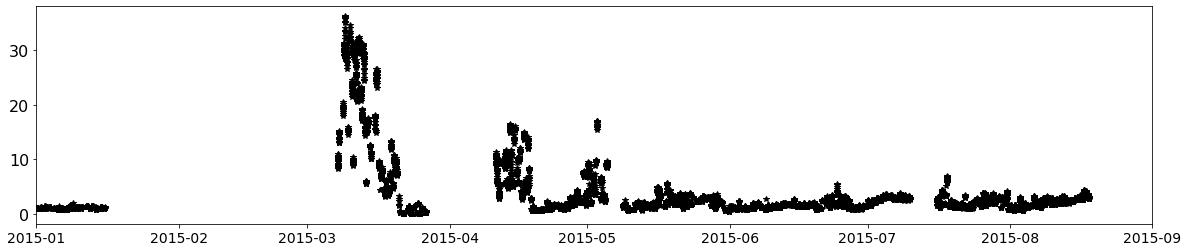

In [13]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*')
ax.set_xlim(dt.datetime(2015,1,1),dt.datetime(2015,9,1))

In [14]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days
fnum=18 # number of results files per run
runlen=fdur*fnum # length of run in days
#stm=np.shape(tmask)

In [15]:
sdir='/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812' # leave off trailing /!

idir='tvdTune_201812'

In [16]:
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}

In [17]:
ff=dict()
for pl in plist:
    print(sdir+'/ts_'+idir+'_'+varNameDict[pl]+'.nc')
    ff[pl]=nc.Dataset(sdir+'/ts_'+idir+'_'+varNameDict[pl]+'.nc')

/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812/ts_tvdTune_201812_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812/ts_tvdTune_201812_S3.nc
/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812/ts_tvdTune_201812_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/BelugaRuns/tvdTune_201812/ts_tvdTune_201812_CentralSJDF.nc


In [18]:
f=ff['S3']
torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
print(torig)
times=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00


In [19]:
xl=[times[0],times[-1]]

In [20]:
f=ff['S3']
fcomp=nc.Dataset('/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_HC201812_2015_S3.nc')
torig=dt.datetime.strptime(fcomp.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
print(torig)
timescomp=np.array([torig + dt.timedelta(seconds=ii) for ii in fcomp.variables['time_centered'][:]])

1900-01-01 00:00:00


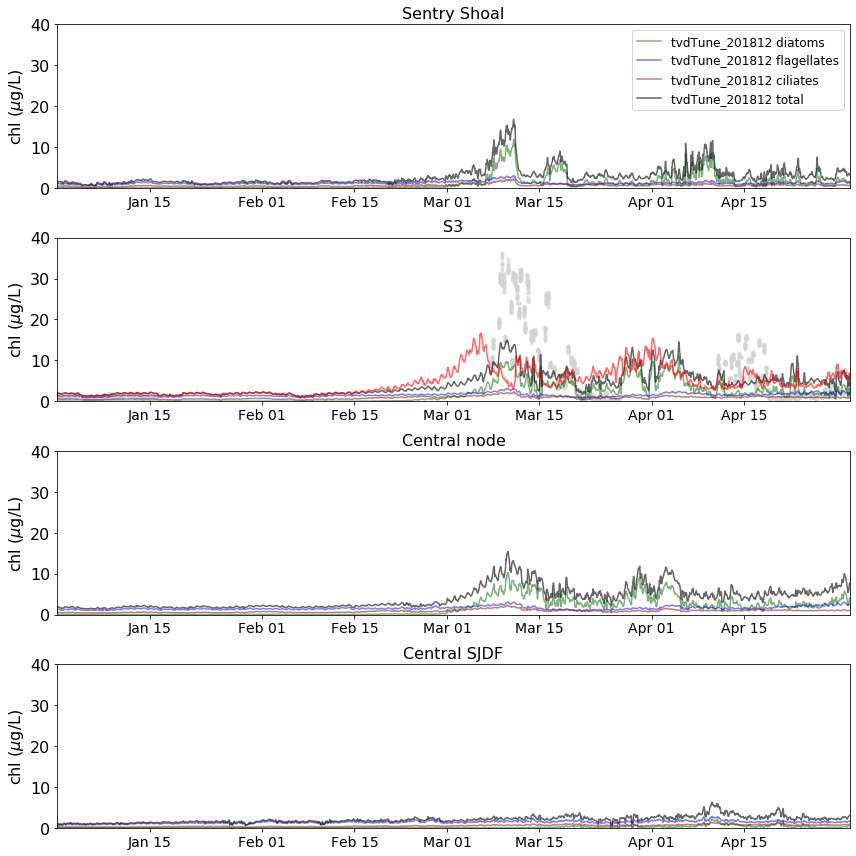

In [21]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(len(plist),1,figsize=(12,3*(len(plist))))
pp=dict()
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='lightgray',alpha=.5)
    pp[ii]=dict()
    f=ff[pl]
    for var in ('diatoms','flagellates','ciliates'):
        pp[ii][var]=ax[ii].plot(times,Chl_N*np.sum(f.variables[var][:,:3,0,0]*\
                                                 np.tile(e3t_0[:,:3,0,0],(len(times),1)),1)/\
                                np.sum(np.tile(e3t_0[:,:3,0,0],(len(times),1)),1),
                  linestyle='-',color=cdict[var],alpha=.5,label=idir+' '+var)
    pp[ii]['tot']=ax[ii].plot(times,Chl_N*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+\
                                                f.variables['ciliates'][:,:3,0,0])*\
                                               np.tile(e3t_0[:,:3,0,0],(len(times),1)),1)/\
                              np.sum(np.tile(e3t_0[:,:3,0,0],(len(times),1)),1),
                  linestyle='-',color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)
ax[1].plot(timescomp,Chl_N*np.sum((fcomp.variables['diatoms'][:,:3,0,0]+fcomp.variables['flagellates'][:,:3,0,0]+\
                                                fcomp.variables['ciliates'][:,:3,0,0])*\
                                               np.tile(e3t_0[:,:3,0,0],(len(timescomp),1)),1)/\
                              np.sum(np.tile(e3t_0[:,:3,0,0],(len(timescomp),1)),1),
                  linestyle='-',color='r',alpha=.6,label='HC201812')
plt.tight_layout()



(735599.0208333334, 735718.9791666666)

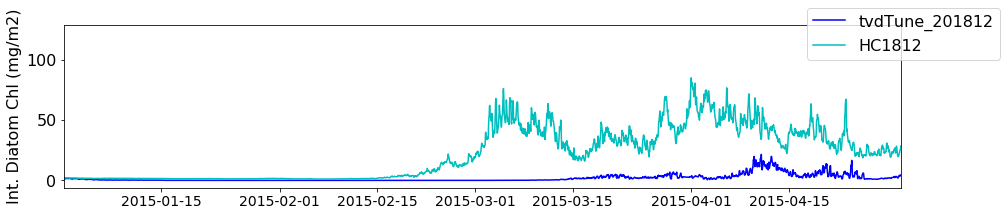

In [22]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(times,np.sum(f.variables['diatoms'][:,:,0,0]*np.tile(e3t_0[:,:,0,0],(len(times),1)),1),'b-',label=idir)
ax.plot(timescomp,np.sum(fcomp.variables['diatoms'][:,:,0,0]*np.tile(e3t_0[:,:,0,0],(len(timescomp),1)),1),'c-',label='HC1812')
fig.legend()
ax.set_ylabel('Int. Diatom Chl (mg/m2)')
ax.set_xlim(xl)

(735599.0208333334, 735718.9791666666)

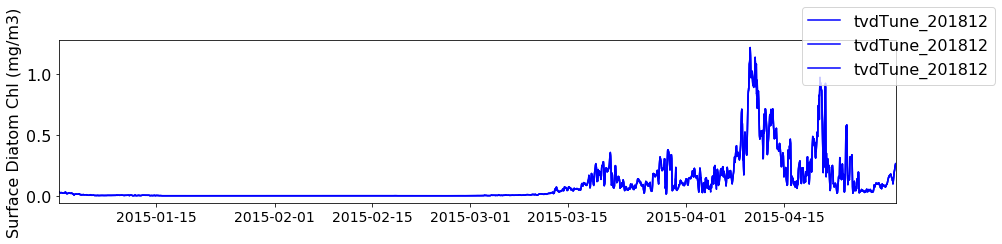

In [29]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(times,f.variables['diatoms'][:,:3,0,0],'b-',label=idir)
#ax.plot(timescomp,fcomp.variables['diatoms'][:,:3,0,0],'c-',label='HC1812')
fig.legend()
ax.set_ylabel('Surface Diatom Chl (mg/m3)')
ax.set_xlim(xl)

Text(0.5, 1.0, 'NO3 (mmol/m3)')

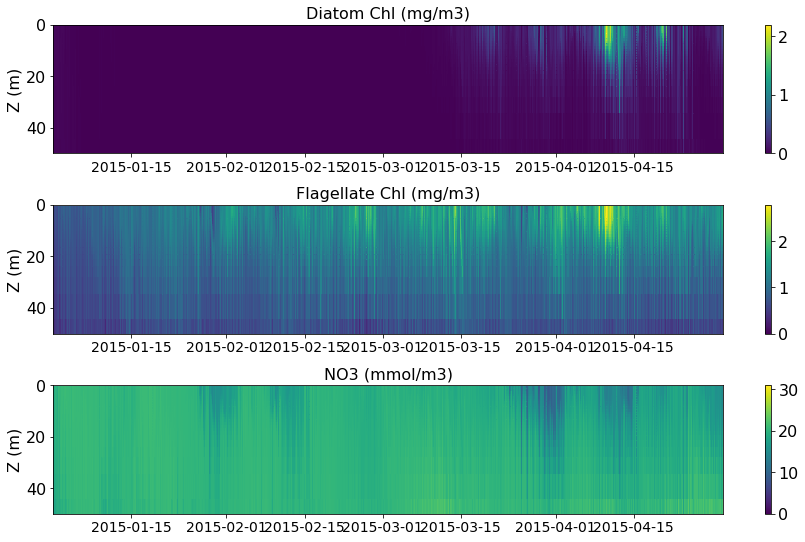

In [23]:
# diatoms, nitrogen
fig,ax=plt.subplots(3,1,figsize=(15,9))
fig.subplots_adjust(hspace=.4)

z=f.variables['deptht'][:]
m0=ax[0].pcolormesh(times,z,Chl_N*f.variables['diatoms'][:,:,0,0].T)
fig.colorbar(m0,ax=ax[0])
ax[0].set_ylim(50,0)
ax[0].set_ylabel('Z (m)')
ax[0].set_title('Diatom Chl (mg/m3)')

m1=ax[1].pcolormesh(times,z,Chl_N*f.variables['flagellates'][:,:,0,0].T)
fig.colorbar(m1,ax=ax[1])
ax[1].set_ylim(50,0)
ax[1].set_ylabel('Z (m)')
ax[1].set_title('Flagellate Chl (mg/m3)')

m2=ax[2].pcolormesh(times,z,f.variables['nitrate'][:,:,0,0].T)
fig.colorbar(m2,ax=ax[2])
ax[2].set_ylim(50,0)
ax[2].set_ylabel('Z (m)')
ax[2].set_title('NO3 (mmol/m3)')

Text(0.5, 1.0, 'HC1812 NO3 (mmol/m3)')

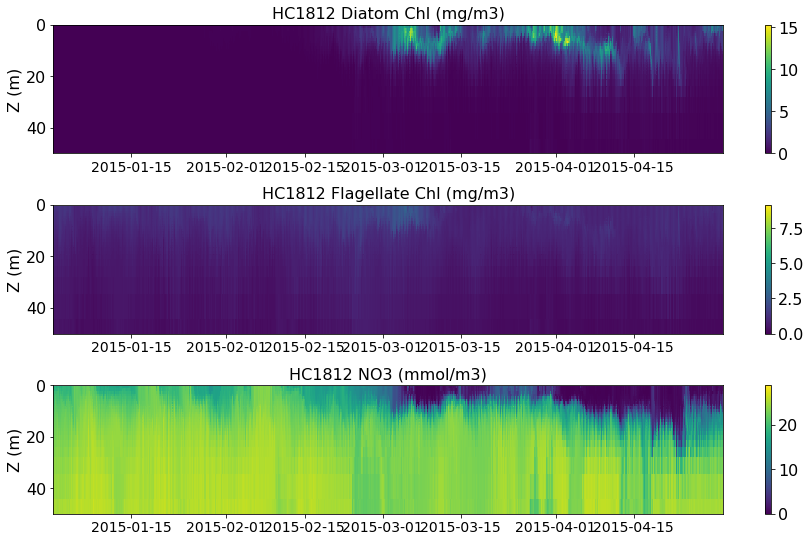

In [24]:
# diatoms, nitrogen
fig,ax=plt.subplots(3,1,figsize=(15,9))
fig.subplots_adjust(hspace=.4)
z=f.variables['deptht'][:]
m0=ax[0].pcolormesh(timescomp,z,Chl_N*fcomp.variables['diatoms'][:,:,0,0].T)
fig.colorbar(m0,ax=ax[0])
ax[0].set_xlim(xl)
ax[0].set_ylim(50,0)
ax[0].set_ylabel('Z (m)')
ax[0].set_title('HC1812 Diatom Chl (mg/m3)')

m1=ax[1].pcolormesh(timescomp,z,Chl_N*fcomp.variables['flagellates'][:,:,0,0].T)
fig.colorbar(m1,ax=ax[1])
ax[1].set_xlim(xl)
ax[1].set_ylim(50,0)
ax[1].set_ylabel('Z (m)')
ax[1].set_title('HC1812 Flagellate Chl (mg/m3)')

m2=ax[2].pcolormesh(timescomp,z,fcomp.variables['nitrate'][:,:,0,0].T)
fig.colorbar(m2,ax=ax[2])
ax[2].set_xlim(xl)
ax[2].set_ylim(50,0)
ax[2].set_ylabel('Z (m)')
ax[2].set_title('HC1812 NO3 (mmol/m3)')

### Difference plots

Text(0.5, 1.0, 'Difference NO3 (mmol/m3)')

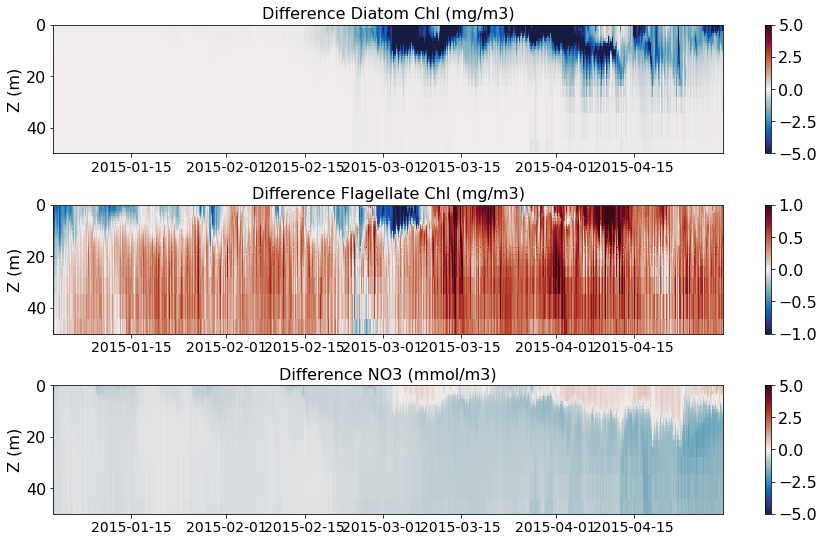

In [25]:
# diatoms, nitrogen
tl=len(times)
fig,ax=plt.subplots(3,1,figsize=(15,9))
fig.subplots_adjust(hspace=.4)
z=f.variables['deptht'][:]
m0=ax[0].pcolormesh(times,z,Chl_N*(f.variables['diatoms'][:,:,0,0].T-fcomp.variables['diatoms'][:tl,:,0,0].T),
                    vmin=-5,vmax=5,cmap=cmocean.cm.balance)
fig.colorbar(m0,ax=ax[0])
ax[0].set_ylim(50,0)
ax[0].set_ylabel('Z (m)')
ax[0].set_title('Difference Diatom Chl (mg/m3)')

m1=ax[1].pcolormesh(times,z,Chl_N*(f.variables['flagellates'][:,:,0,0].T-fcomp.variables['flagellates'][:tl,:,0,0].T),
                    vmin=-1,vmax=1,cmap=cmocean.cm.balance)
fig.colorbar(m1,ax=ax[1])
ax[1].set_ylim(50,0)
ax[1].set_ylabel('Z (m)')
ax[1].set_title('Difference Flagellate Chl (mg/m3)')

m2=ax[2].pcolormesh(times,z,(f.variables['ammonium'][:,:,0,0].T-fcomp.variables['ammonium'][:tl,:,0,0].T),
                    vmin=-5,vmax=5,cmap=cmocean.cm.balance)
fig.colorbar(m2,ax=ax[2])
ax[2].set_ylim(50,0)
ax[2].set_ylabel('Z (m)')
ax[2].set_title('Difference NO3 (mmol/m3)')

(735599.0, 735644.0)

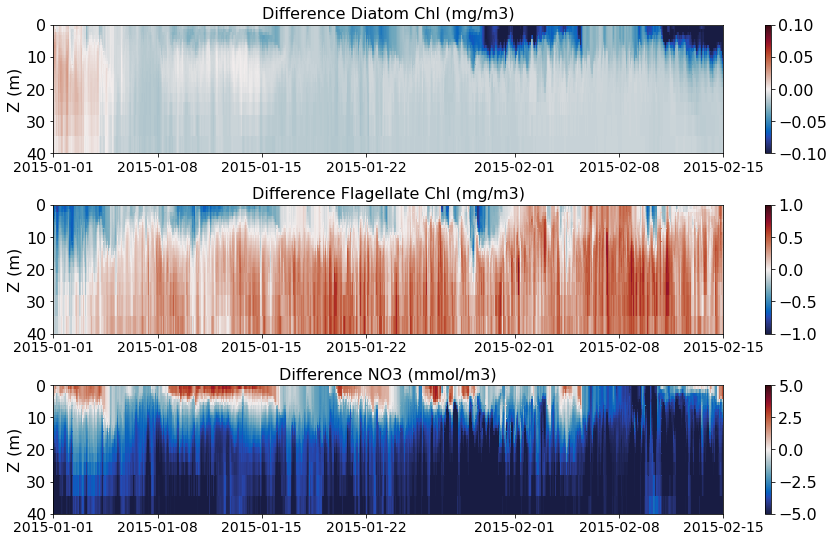

In [26]:
xl2=[dt.datetime(2015,1,1),dt.datetime(2015,2,15)]
# diatoms, nitrogen
fig,ax=plt.subplots(3,1,figsize=(15,9))
fig.subplots_adjust(hspace=.4)
z=f.variables['deptht'][:]
m0=ax[0].pcolormesh(times,z,Chl_N*(f.variables['diatoms'][:,:,0,0].T-fcomp.variables['diatoms'][:tl,:,0,0].T),
                    vmin=-.1,vmax=.1,cmap=cmocean.cm.balance)
fig.colorbar(m0,ax=ax[0])
ax[0].set_ylim(40,0)
ax[0].set_ylabel('Z (m)')
ax[0].set_title('Difference Diatom Chl (mg/m3)')
ax[0].set_xlim(xl2)

m1=ax[1].pcolormesh(times,z,Chl_N*(f.variables['flagellates'][:,:,0,0].T-fcomp.variables['flagellates'][:tl,:,0,0].T),
                    vmin=-1,vmax=1,cmap=cmocean.cm.balance)
fig.colorbar(m1,ax=ax[1])
ax[1].set_ylim(40,0)
ax[1].set_ylabel('Z (m)')
ax[1].set_title('Difference Flagellate Chl (mg/m3)')
ax[1].set_xlim(xl2)

m2=ax[2].pcolormesh(times,z,(f.variables['nitrate'][:,:,0,0].T-fcomp.variables['nitrate'][:tl,:,0,0].T),
                    vmin=-5,vmax=5,cmap=cmocean.cm.balance)
fig.colorbar(m2,ax=ax[2])
ax[2].set_ylim(40,0)
ax[2].set_ylabel('Z (m)')
ax[2].set_title('Difference NO3 (mmol/m3)')
ax[2].set_xlim(xl2)

KeyError: 'particulate_organic_nitrogen'

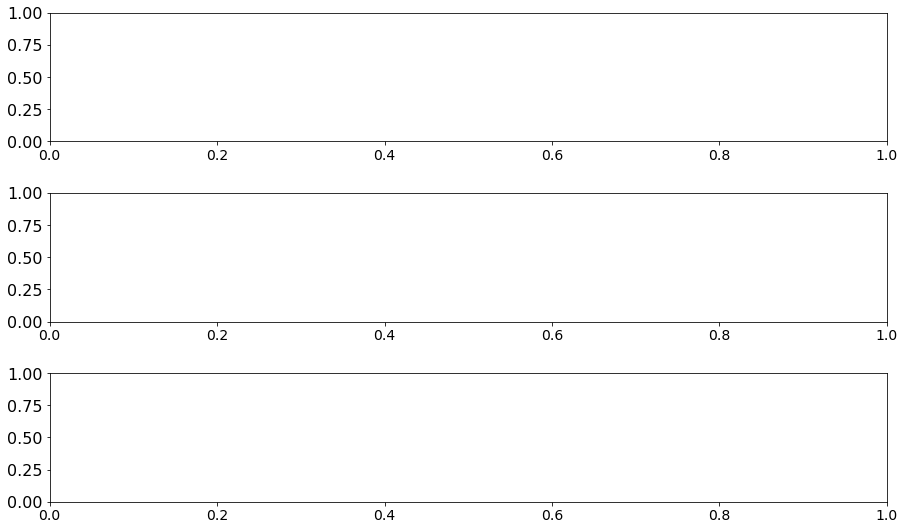

In [27]:
xl2=[dt.datetime(2015,1,1),dt.datetime(2015,2,15)]
# diatoms, nitrogen
fig,ax=plt.subplots(3,1,figsize=(15,9))
fig.subplots_adjust(hspace=.4)
z=f.variables['deptht'][:]
m0=ax[0].pcolormesh(times,z,(f.variables['particulate_organic_nitrogen'][:,:,0,0].T-fcomp.variables['particulate_organic_nitrogen'][:tl,:,0,0].T),
                    vmin=-.1,vmax=.1,cmap=cmocean.cm.balance)
fig.colorbar(m0,ax=ax[0])
ax[0].set_ylim(40,0)
ax[0].set_ylabel('Z (m)')
ax[0].set_title('Difference PON')
ax[0].set_xlim(xl2)

m1=ax[1].pcolormesh(times,z,(f.variables['biogenic_silicon'][:,:,0,0].T-fcomp.variables['biogenic_silicon'][:tl,:,0,0].T),
                    vmin=-1,vmax=1,cmap=cmocean.cm.balance)
fig.colorbar(m1,ax=ax[1])
ax[1].set_ylim(40,0)
ax[1].set_ylabel('Z (m)')
ax[1].set_title('Difference bSi')
ax[1].set_xlim(xl2)

m2=ax[2].pcolormesh(times,z,(f.variables['diatoms'][:,:,0,0].T-fcomp.variables['diatoms'][:tl,:,0,0].T),
                    vmin=-5,vmax=5,cmap=cmocean.cm.balance)
fig.colorbar(m2,ax=ax[2])
ax[2].set_ylim(40,0)
ax[2].set_ylabel('Z (m)')
ax[2].set_title('Difference Diatoms')
ax[2].set_xlim(xl2)

In [ ]:
fcomp.variables.keys()